# TP2

## Integrantes
1. a1818 Daniel Fernando Peña Pinzon (danielfer.colt01@gmail.com)
2. a1820 Nicolas Pinzon Aparicio	(npinzonaparicio@gmail.com)


### librerias

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

### proceso

In [3]:
def calculate_sharpness_measure(frame):
    if len(frame.shape) > 2:
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    else:
        gray = frame.copy()

    gray = cv2.equalizeHist(gray)

    f = np.fft.fft2(gray)
    fshift = np.fft.fftshift(f)

    magnitude_spectrum = np.abs(fshift)

    magnitude_spectrum_log = np.log1p(magnitude_spectrum)

    normalized_spectrum = magnitude_spectrum / np.max(magnitude_spectrum)


    rows, cols = gray.shape
    center_row, center_col = rows // 2, cols // 2

    y, x = np.ogrid[-center_row:rows-center_row, -center_col:cols-center_col]
    distance_from_center = np.sqrt(x*x + y*y)

    highpass_filter = distance_from_center / np.max(distance_from_center)

    weighted_spectrum = normalized_spectrum * highpass_filter

    ism = np.sum(weighted_spectrum) / (rows * cols)

    return ism

In [13]:
def create_focus_matrix(frame, block_size=32):
    if len(frame.shape) > 2:
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    else:
        gray = frame.copy()

    height, width = gray.shape

    num_blocks_y = height // block_size
    num_blocks_x = width // block_size

    focus_matrix = np.zeros((num_blocks_y, num_blocks_x))

    for y in range(num_blocks_y):
        for x in range(num_blocks_x):
            block = gray[y*block_size:(y+1)*block_size, x*block_size:(x+1)*block_size]

            focus_score = calculate_sharpness_measure(block)
            focus_matrix[y, x] = focus_score

    visualization = frame.copy()
    max_score = np.max(focus_matrix)

    for y in range(num_blocks_y):
        for x in range(num_blocks_x):
            normalized_score = focus_matrix[y, x] / max_score

            if normalized_score > 0.5:  # Mostrar solo bloques con buena nitidez
                # Color verde más intenso = más enfocado, como en la diapositiva
                color = (0, 255, 0)  # Verde fijo como en la diapositiva

                cv2.rectangle(
                    visualization,
                    (x * block_size, y * block_size),
                    ((x + 1) * block_size, (y + 1) * block_size),
                    color,
                    1
                )

    return focus_matrix, visualization

In [5]:
def define_roi(frame, percentage=10):
    height, width = frame.shape[:2]

    # Calcular el área total y el área de la ROI
    total_area = height * width
    roi_area = total_area * percentage / 100

    # Calcular las dimensiones de la ROI (cuadrada o rectangular según las proporciones)
    aspect_ratio = width / height
    roi_height = int(np.sqrt(roi_area / aspect_ratio))
    roi_width = int(roi_height * aspect_ratio)

    # Calcular las coordenadas de la ROI (centrada)
    roi_x = (width - roi_width) // 2
    roi_y = (height - roi_height) // 2

    return (roi_x, roi_y, roi_width, roi_height)

In [6]:
def unsharp_masking(image, kernel_size=(5, 5), sigma=1.0, k=1.0, threshold=0):
    # Paso 1: Desenfoque de la imagen con un filtro suavizador (Gaussiano)
    # f(x,y) → f_B(x,y)
    blurred = cv2.GaussianBlur(image, kernel_size, sigma)

    # Implementación directa de la fórmula: g(x,y) = (k+1)·f(x,y) - k·f_B(x,y)
    # Como se muestra exactamente en la diapositiva 12
    sharpened = (k + 1) * image - k * blurred

    # Asegurar que los valores estén dentro del rango válido [0, 255]
    sharpened = np.clip(sharpened, 0, 255).astype(np.uint8)

    # Si se especifica un umbral, solo aplicar el efecto a áreas con
    # suficiente contraste (donde la diferencia es mayor que el umbral)
    if threshold > 0:
        low_contrast_mask = np.absolute(image - blurred) < threshold
        np.copyto(sharpened, image, where=low_contrast_mask)

    return sharpened

In [7]:
def process_video(video_path):
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print(f"Error: No se pudo abrir el video {video_path}")
        return None

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS)

    ret, first_frame = cap.read()
    if not ret:
        print("Error: No se pudo leer el primer frame")
        cap.release()
        return None

    # ROI para el experimento 2
    roi = define_roi(first_frame, percentage=7)

    cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

    full_frame_scores = []
    roi_scores = []
    frames = []

    # Procesar cada frame
    for i in tqdm(range(total_frames)):
        ret, frame = cap.read()
        if not ret:
            break

        frames.append(frame.copy())

        score_full = calculate_sharpness_measure(frame)
        full_frame_scores.append(score_full)

        x, y, w, h = roi
        roi_frame = frame[y:y+h, x:x+w]
        score_roi = calculate_sharpness_measure(roi_frame)
        roi_scores.append(score_roi)

    cap.release()

    max_score_full_idx = np.argmax(full_frame_scores)
    max_score_roi_idx = np.argmax(roi_scores)

    max_focus_frame_full = frames[max_score_full_idx]
    max_focus_frame_roi = frames[max_score_roi_idx]

    focus_matrix, focus_visualization = create_focus_matrix(max_focus_frame_full)

    enhanced_frame = unsharp_masking(max_focus_frame_full, k=2.0)

    # Recopilar resultados
    results = {
        'full_frame_scores': full_frame_scores,
        'roi_scores': roi_scores,
        'max_focus_frame_full_idx': max_score_full_idx,
        'max_focus_frame_roi_idx': max_score_roi_idx,
        'max_focus_frame_full': max_focus_frame_full,
        'max_focus_frame_roi': max_focus_frame_roi,
        'focus_matrix': focus_matrix,
        'focus_visualization': focus_visualization,
        'enhanced_frame': enhanced_frame,
        'frames': frames,
        'roi': roi,
        'fps': fps
    }

    return results

In [12]:
def plot_results(results):
    full_frame_scores = results['full_frame_scores']
    roi_scores = results['roi_scores']
    max_focus_frame_full_idx = results['max_focus_frame_full_idx']
    max_focus_frame_roi_idx = results['max_focus_frame_roi_idx']
    max_focus_frame_full = results['max_focus_frame_full']
    max_focus_frame_roi = results['max_focus_frame_roi']
    focus_visualization = results['focus_visualization']
    enhanced_frame = results['enhanced_frame']
    roi = results['roi']

    # Convertir a RGB para matplotlib
    max_focus_frame_full_rgb = cv2.cvtColor(max_focus_frame_full, cv2.COLOR_BGR2RGB)
    max_focus_frame_roi_rgb = cv2.cvtColor(max_focus_frame_roi, cv2.COLOR_BGR2RGB)
    focus_visualization_rgb = cv2.cvtColor(focus_visualization, cv2.COLOR_BGR2RGB)
    enhanced_frame_rgb = cv2.cvtColor(enhanced_frame, cv2.COLOR_BGR2RGB)

    # ROI en el frame
    roi_frame = max_focus_frame_roi.copy()
    x, y, w, h = roi
    cv2.rectangle(roi_frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
    roi_frame_rgb = cv2.cvtColor(roi_frame, cv2.COLOR_BGR2RGB)

    # Figura 1: Curvas de métrica de enfoque
    plt.figure(figsize=(12, 5))
    plt.plot(full_frame_scores, '-b', label='Frame Completo')
    plt.plot(roi_scores, '-r', label='ROI Central')
    plt.axvline(x=max_focus_frame_full_idx, color='b', linestyle='--', label=f'Máximo Frame Completo (Frame {max_focus_frame_full_idx})')
    plt.axvline(x=max_focus_frame_roi_idx, color='r', linestyle='--', label=f'Máximo ROI (Frame {max_focus_frame_roi_idx})')
    plt.xlabel('Frame #')
    plt.ylabel('ISM (Image Sharpness Measure)')
    plt.grid(True)
    plt.legend()
    plt.title('Evolución de la métrica de enfoque a lo largo del video')
    plt.tight_layout()
    plt.savefig('focus_metrics_curves.png')

    # Figura 2: Frames con máximo enfoque
    plt.figure(figsize=(15, 10))

    plt.subplot(2, 2, 1)
    plt.imshow(max_focus_frame_full_rgb)
    plt.title(f'Frame con máximo enfoque global (Frame {max_focus_frame_full_idx})')
    plt.axis('off')

    plt.subplot(2, 2, 2)
    plt.imshow(roi_frame_rgb)
    plt.title(f'Frame con máximo enfoque en ROI (Frame {max_focus_frame_roi_idx})')
    plt.axis('off')

    plt.subplot(2, 2, 3)
    plt.imshow(focus_visualization_rgb)
    plt.title('Matriz de enfoque superpuesta al frame')
    plt.axis('off')

    plt.subplot(2, 2, 4)
    plt.imshow(enhanced_frame_rgb)
    plt.title('Frame con enfoque mejorado (Unsharp Masking)')
    plt.axis('off')

    plt.tight_layout()
    plt.savefig('focus_detection_results.png')

    plt.show()

Procesando video para detectar puntos de máximo enfoque...


100%|██████████| 171/171 [00:01<00:00, 163.04it/s]


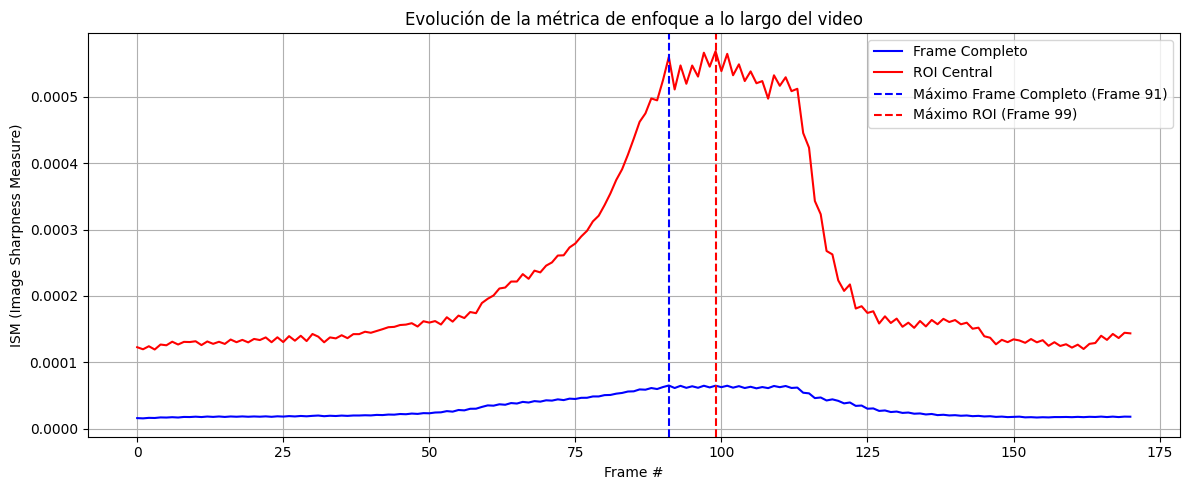

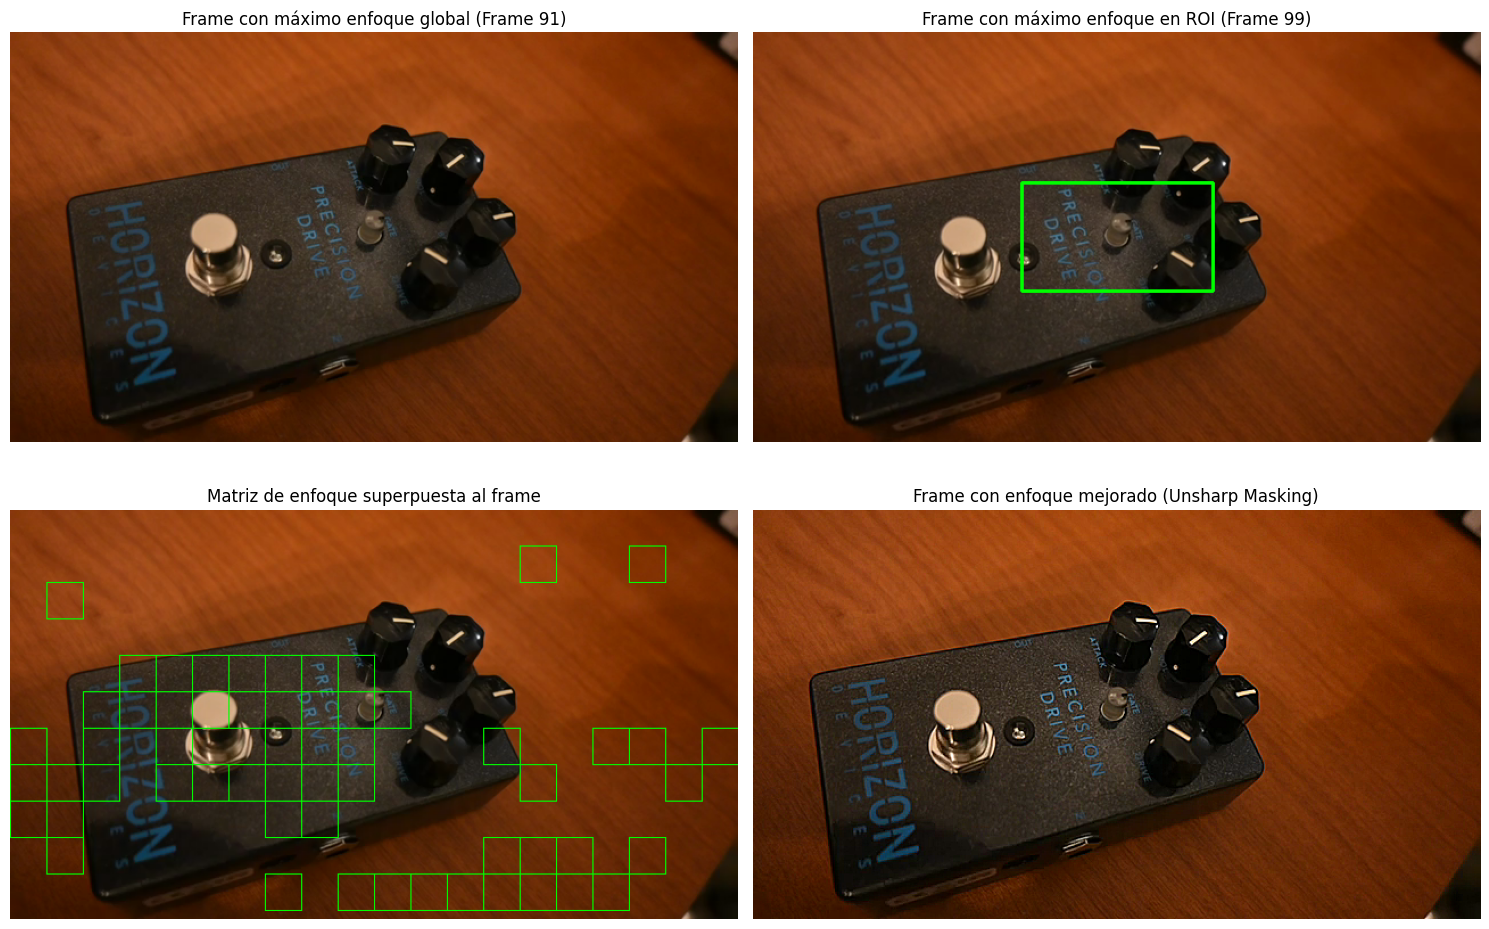


=== RESULTADOS DEL DETECTOR DE MÁXIMO ENFOQUE ===
Frame con máximo enfoque global: 91
Frame con máximo enfoque en ROI: 99

Observaciones:
- Se utilizó la transformada de Fourier para analizar las componentes de frecuencia
- Las altas frecuencias indican un mejor enfoque (bordes y detalles más nítidos)
- Se aplicó unsharp masking para expandir la zona de enfoque

Datos extra:
- Se implementó unsharp masking según la fórmula: g(x,y) = (k+1)·f(x,y) - k·f_B(x,y)
- Se visualizó la matriz de enfoque similar a la diapositiva de la clase


In [14]:
if __name__ == "__main__":
    video_path = "focus_video.mov"

    #Procesar el video para detectar puntos de máximo enfoque
    print("Procesando video para detectar puntos de máximo enfoque...")
    results = process_video(video_path)

    if results:
        plot_results(results)

        print("\n=== RESULTADOS DEL DETECTOR DE MÁXIMO ENFOQUE ===")
        print(f"Frame con máximo enfoque global: {results['max_focus_frame_full_idx']}")
        print(f"Frame con máximo enfoque en ROI: {results['max_focus_frame_roi_idx']}")
        print("\nObservaciones:")
        print("- Se utilizó la transformada de Fourier para analizar las componentes de frecuencia")
        print("- Las altas frecuencias indican un mejor enfoque (bordes y detalles más nítidos)")
        print("- Se aplicó unsharp masking para expandir la zona de enfoque")
        print("\nDatos extra:")
        print("- Se implementó unsharp masking según la fórmula: g(x,y) = (k+1)·f(x,y) - k·f_B(x,y)")
        print("- Se visualizó la matriz de enfoque similar a la diapositiva de la clase")